In [2]:
library(SymSim)
library(SingleCellExperiment)
library(Seurat)

library(mclust)
library(scran)
library(Matrix)

Loading required package: plyr

Loading required package: ggplot2

Loading required package: Rtsne

Loading required package: grid

Loading required package: reshape


Attaching package: ‘reshape’


The following objects are masked from ‘package:plyr’:

    rename, round_any


Loading required package: RColorBrewer

Loading required package: Biobase

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, inte

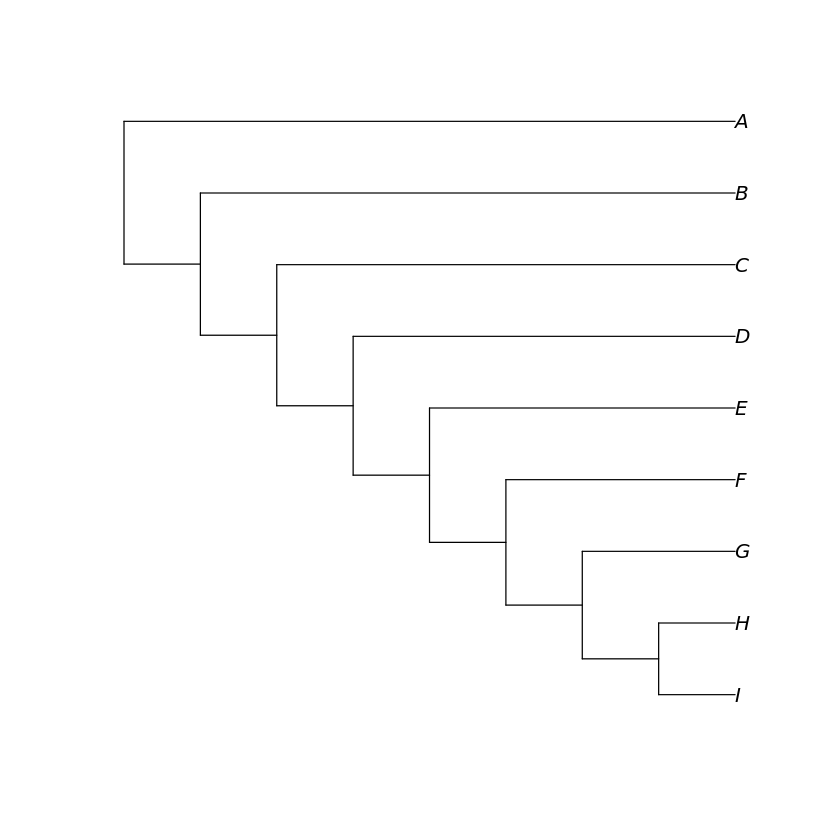

In [4]:
phyla_disc <- read.tree('tree_sameend.txt')
#par(mfrow=c(1,2))
plot(phyla_disc)

In [5]:
filter_exp <-function(sce,pct){
    expsn <- rowMeans(logcounts(sce))
    keep <- order(expsn, decreasing = TRUE)[seq_len(pct/100*length(expsn))]
    sce_filtered <- sce[keep, ]  
    
    sce_filtered
}

save_sce <- function(sce,path,lowdim='TSNE'){
    
    sizeFactors(sce) <- calculateSumFactors(sce)
    
    save_data <- Matrix(as.matrix(assay(sce,'counts')),sparse=TRUE)
    
    writeMM(save_data,sprintf("%s.data.counts.mm",path))
    write.table(as.matrix(rownames(save_data)),sprintf('%s.data.row',path),row.names=FALSE, col.names=FALSE)
    write.table(as.matrix(colnames(save_data)),sprintf('%s.data.col',path),row.names=FALSE, col.names=FALSE)
    
    tsne_data <- reducedDim(sce, lowdim)
    colnames(tsne_data) <- c(sprintf('%s_1',lowdim),sprintf('%s_2',lowdim))
    print(head(cbind(as.matrix(colData(sce)),tsne_data)))
    write.table(cbind(as.matrix(colData(sce)),tsne_data),sprintf('%s.metadatacol.tsv',path),row.names=TRUE, col.names=TRUE,sep='\t')    
    write.table(cbind(as.matrix(rowData(sce))),sprintf('%s.metadatarow.tsv',path),row.names=TRUE, col.names=TRUE,sep='\t')    
    
    write.table(sizeFactors(sce),file=sprintf('%s.size_factor.tsv',path),sep='\t',row.names=FALSE, col.names=FALSE)    
    
}

save_hvg_seurat <-function(sce,path,method){
    seurat <- CreateSeuratObject(counts = counts(sce), project = "scRNAseq", assay = "RNA",
                                         min.cells = 0, min.features = 0,
                                         meta.data = as.data.frame(colData(sce)))
    #seurat <- ScaleData(seurat, vars.to.regress = "nUMI", display.progress = FALSE)
    seurat <- NormalizeData(seurat)
    seurat <- FindVariableFeatures(seurat, selection.method = method, nfeatures = length(rownames(seurat@assays$RNA)))
    vf <- VariableFeatures(seurat)  
    write.table(vf,file=sprintf('%s.hvg.%s.tsv',path,method),sep='\t',row.names=FALSE, col.names=TRUE)       
}

In [6]:
for(i in c(6:10)){
    #############
    #True counts
    #############
    disc_true_counts <- SimulateTrueCounts(ncells_total=1000, 
                                          min_popsize=50, 
                                          i_minpop=1, 
                                          ngenes=5000, 
                                          nevf=20, 
                                          evf_type="discrete", 
                                          n_de_evf=5,
                                          vary="s",
                                          geffect_mean=1,
                                          Sigma=0.4,
                                          bimod = 1,
                                          phyla=phyla_disc,
                                          gene_effect_prob=0.01,
                                          randseed=i)
    
    if(FALSE){
        disc_true_counts_tsne <- PlotTsne(meta=disc_true_counts[[3]][,c('cellid','pop')],
                                     data=log2(disc_true_counts[[1]]+1),
                                     evf_type="discrete",
                                     n_pc=30,
                                     label='pop',
                                     saving = F,
                                     plotname="discrete populations (true counts)")
        disc_true_counts_tsne[[2]]        
    }
    
    
    #############
    #Observed counts
    #############    
    
    gene_len <- sample(gene_len_pool, 5000, replace = FALSE)
    
    
    disc_observed_UMI <- True2ObservedCounts(true_counts=disc_true_counts[[1]],
                                             meta_cell=disc_true_counts[[3]],
                                             protocol="UMI",
                                             alpha_mean=0.05,
                                             alpha_sd=0.02,
                                             gene_len=gene_len,
                                             depth_mean=5e5,
                                             depth_sd=3e4)   
    
    if(FALSE){
        disc_observed_UMI_tsne <- PlotTsne(meta=disc_observed_UMI[[2]],
                                           data=log2(disc_observed_UMI[[1]]+1),
                                           evf_type="discrete",
                                           n_pc=20,
                                           label='pop',
                                           saving = F,
                                           plotname="observed counts UMI")
        disc_observed_UMI_tsne[[2]]           
    }
    
    #############
    #Saving
    #############    
    
    
    count=disc_observed_UMI[[1]]
    colnames(count)=c(disc_observed_UMI[[2]]['cellid'])$cellid
    rownames(count)=c(1:dim(count)[1])
 
    seurat <- CreateSeuratObject(counts = count)
    seurat@meta.data$phenoid=c(disc_observed_UMI[[2]]['pop'])$pop    
    
    seurat=FindVariableFeatures(seurat, selection.method = "vst", nfeatures = 2000)

    seurat_hvg <- NormalizeData(seurat)

    all.genes <- rownames(seurat_hvg)
    seurat_hvg=ScaleData(seurat_hvg,features = all.genes)

    seurat_hvg_pca = RunPCA(seurat_hvg)

    PC_cluster=50
    PC_2D=50

    seurat_hvg_pca <- RunTSNE(seurat_hvg_pca, dims= 1:PC_2D)

    seurat_hvg_pca_label <- FindNeighbors(seurat_hvg_pca, dims = 1:PC_cluster)

    seurat_hvg_pca_label_cluster <- FindClusters(seurat_hvg_pca_label, resolution = 2)

    DimPlot(seurat_hvg_pca_label_cluster,group.by='phenoid',cols = DiscretePalette(22))

    DimPlot(seurat_hvg_pca_label_cluster,group.by='seurat_clusters',cols = DiscretePalette(22))

    print(adjustedRandIndex(seurat@meta.data$phenoid, seurat_hvg_pca_label_cluster@meta.data$seurat_clusters))

    
    sce_full_Simul <- as.SingleCellExperiment(seurat_hvg_pca_label_cluster)
    
    sce_full_Simul_expfiltered=filter_exp(sce_full_Simul,30)
    
    
    path=sprintf('datasets/extract/Simul_1_1e-2_%s_filtered',i)
    
    save_sce(sce_full_Simul_expfiltered, path)

    for(method in c('vst','mvp','disp')){
        save_hvg_seurat(sce_full_Simul_expfiltered, path, method)
    }    
    
    
}

Centering and scaling data matrix

PC_ 1 
Positive:  1438, 374, 2052, 4221, 2215, 3800, 4882, 4898, 3534, 4883 
	   4684, 3092, 2563, 3481, 2803, 2885, 2881, 3019, 4241, 2574 
	   3454, 3565, 3719, 2867, 4330, 1158, 1736, 1562, 1929, 2135 
Negative:  2905, 2646, 4396, 2477, 4516, 3824, 4645, 4851, 2971, 4832 
	   3452, 4231, 2601, 82, 1866, 604, 454, 1501, 2414, 1259 
	   1814, 1480, 1521, 1083, 641, 3311, 3303, 630, 1298, 1696 
PC_ 2 
Positive:  2240, 4776, 1516, 3269, 2696, 4953, 3961, 4321, 4083, 809 
	   1344, 4841, 4899, 3519, 3759, 1259, 1814, 2232, 2857, 3890 
	   3638, 4468, 4080, 2642, 1298, 3977, 3464, 4729, 4193, 4096 
Negative:  2052, 4684, 374, 1438, 3534, 2215, 4882, 4883, 2563, 3019 
	   2881, 4221, 2885, 4898, 3800, 3481, 3454, 2803, 3092, 2337 
	   1736, 2135, 1158, 4241, 1562, 3565, 1929, 2484, 3719, 2867 
PC_ 3 
Positive:  4575, 3303, 358, 1696, 3311, 4271, 4805, 2624, 3072, 4658 
	   628, 630, 3806, 256, 1760, 3797, 930, 3893, 1618, 4985 
	   456, 1980, 1504, 825, 2

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1000
Number of edges: 68622

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.4150
Number of communities: 10
Elapsed time: 0 seconds
[1] 0.5025691
       orig.ident nCount_RNA nFeature_RNA phenoid RNA_snn_res.2 seurat_clusters
cell_1          1      35289         2940       1             1               1
cell_2          1      23946         2644       1             1               1
cell_3          1      17523         2246       1             1               1
cell_4          1      24996         2737       1             1               1
cell_5          1      25488         2809       1             1               1
cell_6          1      16807         2371       1             1               1
       ident    TSNE_1     TSNE_2
cell_1     1 -2.759957  2.0702528
cell_2     1 -1.149316  1.6876215
cell_3     1 -9.187028 -7.6431681
cell_4     1 -6.757827  5.5681751
cell_5     

Centering and scaling data matrix

PC_ 1 
Positive:  3738, 2764, 4461, 832, 1025, 2945, 3088, 2333, 4405, 96 
	   4401, 3056, 3617, 202, 3885, 4446, 2485, 1220, 164, 1521 
	   3635, 1268, 4731, 743, 4302, 2757, 4696, 4171, 1925, 2695 
Negative:  2792, 972, 4931, 4929, 4954, 3521, 4284, 3860, 3893, 3693 
	   4570, 3153, 4430, 3956, 2782, 3768, 4381, 2732, 3726, 4385 
	   1719, 4856, 2557, 4264, 4291, 4293, 3516, 4549, 3928, 2678 
PC_ 2 
Positive:  2973, 2946, 1905, 3621, 3174, 1025, 832, 3617, 3736, 4605 
	   3388, 96, 4654, 4737, 2945, 3008, 2601, 2597, 3088, 4405 
	   4446, 2724, 2702, 1060, 4316, 2779, 4302, 3635, 4326, 2578 
Negative:  2757, 1268, 4731, 164, 2333, 2944, 3144, 3187, 1840, 1912 
	   2625, 2924, 2695, 222, 470, 2594, 4171, 4856, 4570, 347 
	   4498, 4264, 3768, 3302, 4291, 3486, 4385, 4381, 3726, 304 
PC_ 3 
Positive:  1268, 164, 4731, 3144, 4461, 4614, 470, 4415, 3187, 1840 
	   1127, 2508, 2625, 1849, 2944, 3501, 1912, 3738, 3049, 4343 
	   2764, 3240, 4572, 4872, 46

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1000
Number of edges: 70101

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.4418
Number of communities: 8
Elapsed time: 0 seconds
[1] 0.5467303
       orig.ident nCount_RNA nFeature_RNA phenoid RNA_snn_res.2 seurat_clusters
cell_1          1      18371         2376       1             1               1
cell_2          1      23824         2187       1             3               3
cell_3          1      30422         2738       1             3               3
cell_4          1      40380         2793       1             3               3
cell_5          1      19174         2492       1             1               1
cell_6          1      18315         2448       1             3               3
       ident     TSNE_1     TSNE_2
cell_1     1 -0.8652076  4.7878377
cell_2     3  5.6390738  3.2916493
cell_3     3 11.7686630 -0.6114393
cell_4     3  4.5127196  0.6179032
cell_5 

Centering and scaling data matrix

PC_ 1 
Positive:  1885, 2594, 4003, 1980, 4185, 1268, 4018, 2676, 2786, 3797 
	   2675, 3533, 3287, 4273, 2991, 3475, 3545, 2720, 397, 1157 
	   1609, 1994, 407, 1965, 1162, 1320, 61, 532, 2075, 2318 
Negative:  4700, 1259, 1190, 3532, 2253, 3389, 4709, 3298, 3546, 4943 
	   4479, 2820, 66, 2557, 3290, 1648, 1304, 4885, 2317, 3908 
	   139, 49, 2048, 3229, 1947, 4793, 2913, 1668, 4518, 1935 
PC_ 2 
Positive:  1213, 327, 3606, 857, 2730, 4619, 4433, 2814, 3510, 3450 
	   4994, 3966, 2671, 4078, 2759, 4499, 4346, 4302, 4617, 4100 
	   3457, 467, 4551, 2265, 1752, 109, 1679, 1234, 4024, 1977 
Negative:  393, 2801, 3353, 4161, 69, 2833, 4163, 2277, 4514, 4809 
	   4782, 4052, 3703, 1885, 4263, 4018, 1980, 4185, 4324, 978 
	   3533, 2594, 3062, 4003, 2675, 2676, 3287, 3545, 4651, 1441 
PC_ 3 
Positive:  2277, 3703, 3062, 4499, 2730, 1415, 3966, 4302, 3450, 4994 
	   1213, 1538, 4433, 4078, 1752, 4024, 109, 1611, 4346, 1679 
	   3784, 3903, 1212, 1956, 2265

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1000
Number of edges: 77542

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.3527
Number of communities: 13
Elapsed time: 0 seconds


1 singletons identified. 12 final clusters.



[1] 0.5465665
       orig.ident nCount_RNA nFeature_RNA phenoid RNA_snn_res.2 seurat_clusters
cell_1          1      14869         2286       1             1               1
cell_2          1      44446         2815       1             1               1
cell_3          1      20773         2619       1             1               1
cell_4          1      21838         2529       1             1               1
cell_5          1      18130         2356       1             1               1
cell_6          1      34986         3090       1             1               1
       ident    TSNE_1    TSNE_2
cell_1     1  9.803143 -7.813966
cell_2     1  4.868114 -7.017155
cell_3     1  5.548431 -5.279466
cell_4     1 -4.226938  3.320177
cell_5     1  7.876984 -7.612988
cell_6     1  2.587866 -6.053874


Centering and scaling data matrix

PC_ 1 
Positive:  3750, 3317, 1742, 3930, 4045, 906, 2923, 4923, 3268, 2612 
	   3213, 4080, 4467, 3167, 4082, 4401, 2698, 4740, 4386, 3218 
	   3940, 3601, 2266, 1494, 1389, 927, 1024, 233, 198, 2483 
Negative:  2224, 1485, 3337, 3254, 4887, 2458, 3426, 3639, 2296, 2587 
	   4613, 4808, 3677, 2943, 4878, 3376, 2223, 4001, 4516, 4625 
	   4164, 4852, 4461, 3324, 3432, 3076, 2607, 2072, 2902, 3835 
PC_ 2 
Positive:  298, 2624, 4616, 3341, 1064, 4162, 2990, 2722, 4237, 4719 
	   2946, 3895, 2763, 4809, 4993, 3254, 2224, 1485, 3337, 4146 
	   3672, 3376, 3426, 4516, 2587, 4309, 4613, 4932, 4001, 3569 
Negative:  3067, 1340, 4723, 3162, 2883, 3447, 2223, 4808, 2943, 2296 
	   2607, 4403, 1742, 3837, 2458, 4386, 4887, 3835, 2479, 3940 
	   2612, 588, 3639, 4026, 4878, 2241, 4522, 1712, 2396, 917 
PC_ 3 
Positive:  947, 1535, 2072, 1301, 3930, 4401, 2698, 3268, 1742, 1340 
	   4386, 1494, 1677, 692, 3455, 3761, 3162, 3067, 4790, 2244 
	   3447, 3554, 2948, 

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1000
Number of edges: 75537

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.4406
Number of communities: 8
Elapsed time: 0 seconds


1 singletons identified. 7 final clusters.



[1] 0.4640544
       orig.ident nCount_RNA nFeature_RNA phenoid RNA_snn_res.2 seurat_clusters
cell_1          1      26763         2767       1             3               3
cell_2          1       8180         1709       1             3               3
cell_3          1      20482         2621       1             3               3
cell_4          1      30164         2874       1             3               3
cell_5          1      23035         2605       1             3               3
cell_6          1      15838         2231       1             3               3
       ident   TSNE_1    TSNE_2
cell_1     3 10.67308 -3.473428
cell_2     3 12.22027 -4.602434
cell_3     3 18.51620 -3.565648
cell_4     3 15.44483 -2.345779
cell_5     3 13.41163 -2.481266
cell_6     3 13.65331 -1.775150


Centering and scaling data matrix

PC_ 1 
Positive:  3154, 1832, 253, 3338, 3534, 2625, 3233, 2913, 2656, 4598 
	   3580, 1477, 2312, 4015, 1722, 1824, 2142, 516, 2852, 4955 
	   4553, 2822, 4602, 3439, 2729, 1001, 4582, 3108, 1377, 3100 
Negative:  3005, 4181, 823, 4105, 3200, 4233, 3707, 4638, 4307, 2579 
	   3879, 1847, 2309, 2718, 4936, 3702, 3953, 4507, 4509, 4824 
	   3381, 4386, 2747, 490, 2537, 244, 4872, 2515, 76, 3075 
PC_ 2 
Positive:  490, 244, 3075, 2685, 3970, 2747, 4872, 3381, 4598, 2625 
	   3233, 4180, 2913, 2656, 1949, 1614, 425, 3828, 4087, 1796 
	   2208, 3252, 1892, 577, 1477, 516, 378, 1426, 4638, 744 
Negative:  1847, 3702, 2309, 3573, 4241, 4710, 3680, 2556, 4553, 4083 
	   2729, 2902, 2852, 1001, 4955, 1016, 3439, 2945, 2822, 1884 
	   4849, 3607, 4602, 4028, 2145, 1377, 2291, 3308, 1747, 2247 
PC_ 3 
Positive:  244, 2685, 3075, 490, 2747, 4872, 3534, 3970, 253, 1832 
	   4180, 3828, 3252, 4087, 1796, 378, 577, 1614, 425, 2208 
	   1949, 2309, 1847, 4241, 693, 

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1000
Number of edges: 88124

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.2202
Number of communities: 19
Elapsed time: 0 seconds


2 singletons identified. 17 final clusters.



[1] 0.4096234
       orig.ident nCount_RNA nFeature_RNA phenoid RNA_snn_res.2 seurat_clusters
cell_1          1      29312         3011       1             2               2
cell_2          1      18841         2577       1            12               5
cell_3          1      17003         2351       1            11               4
cell_4          1      20562         2674       1             3              11
cell_5          1      17599         2535       1            14               7
cell_6          1      23691         2842       1            12               5
       ident    TSNE_1    TSNE_2
cell_1     2 1.8170596 -9.025335
cell_2     5 0.6874378 -6.917772
cell_3     4 7.0956123 -5.115148
cell_4    11 3.3640085 -3.897435
cell_5     7 8.3785148 -5.698294
cell_6     5 1.5425780 -7.659840


In [5]:
#help(SimulateTrueCounts)
#0.01, 0.005, 0.001, 0.0005 0.0001

In [ ]:
'datasets/extract/Kohinbulk_filtered'

In [12]:
#saveRDS(disc_observed_UMI, file = "datasets/simul/disc_observed_UMI12.rds")

In [13]:
#saveRDS(disc_true_counts, file = "datasets/simul/disc_true_counts12.rds")

In [14]:
'datasets/extract/Kohinbulk_filtered'

[1] "datasets/extract/Simul_1_1e-2_5_filtered"

Warning message:
“'normalizeSCE' is deprecated.
Use 'logNormCounts' instead.
See help("Deprecated")”
Warning message:
“'centreSizeFactors' is deprecated.
See help("Deprecated")”


       orig.ident phenoid    tSNE_1     tSNE_2
cell_1          1       1  1.290648 -0.5960434
cell_2          1       1  2.295489 -9.3229477
cell_3          1       1  2.285761 -0.4733488
cell_4          1       1 -3.107209  2.2224019
cell_5          1       1 -2.828975  1.0804327
cell_6          1       1  1.526465 -0.4216981


In [40]:
sce_full_simul=SingleCellExperiment(assays = list(counts = count))

In [41]:
colData(sce_full_simul)$phenoid=c(disc_observed_UMI[[2]]['pop'])$pop

class: SingleCellExperiment 
dim: 500 1000 
metadata(0):
assays(1): counts
rownames(500): 1 2 ... 499 500
rowData names(0):
colnames(1000): cell_1 cell_2 ... cell_999 cell_1000
colData names(0):
reducedDimNames(0):
spikeNames(0):
altExpNames(0):

In [ ]:
sce_full_HumanLiver <- SingleCellExperiment(assays = list(counts = HumanLiverSeurat[['RNA']]@counts))